Several classes have been used in this project such as Node, Snake, State, Problem, Doone, File_reader, BFS, IDS, A_star. snake has makans attribute which is a list of tuples that show the positions of the snake. head to tail of the snake are mapped to the last element of the makans until the first one. Doones is a list which contains several instances of Doone class. Doone has attribtues such as y,x, adad. Adad shows number of the seeds in the given position which can be either 1 or 2. Problem is a class which represents the general information of a given game. These information are width and the height of the world map. Given the positions of the snake and the seeds, problem can create the appropriate state. Moreover, Problem is responsible of processing the possible actions and executing them wiht respect to the given state in the argument. The mechanism which ensures the uniqueness of the states is as follow: each state can be transformed to a tuple. This tuple contains positions of the snake, positions of the seeds and the number of seeds in each position. By, calling the hash finction over a state, this hash will later be stored in a set called explored. One can check whether a state has been seen before or not by checking the explored set. Action are also modeled in coded numbers. 0 represents up and it goes on to 3, in a counter clockwise order. Each node is responosible of holding its state. Additionaly, nodes contain their own explored set in the IDS and a_star algorithms. Nodes also are consisted of the steps taken by the snake which caused their creation. These steps are called moves. Goal state is a state in which the adad attibute of all of the seeds is zero. 

2 heuristics has been used in this project. The better one is computed as follow: first we get the minimum distance between each two nodes. The the underestimated path which must be explored by the snake is the number of the remained seeds - 1 multiplied by this minimum distance plus the distance between the snake and the nearest seed. Moreover, the previous result should be added to the number of 2-adad seeds * the length of the snake since when a given 2-adad seed has been eaten the whole length of the snake must pass from over that seed. Another heuristic is simply counting the number of the remaining adads for each seed and summing them all together. Obviously, the first one is much better. 

In weighted A*, as the weight gets bigger, we sacrifice the optimality in favor of the speed. The reason is the role of the heursitic function will become more significant for bigger weights. Given tables are filled as below.

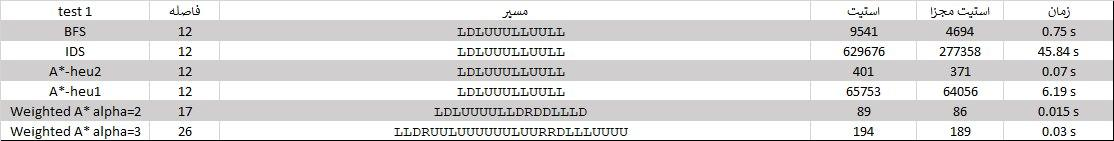

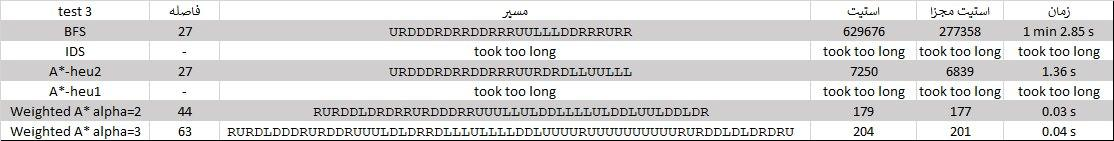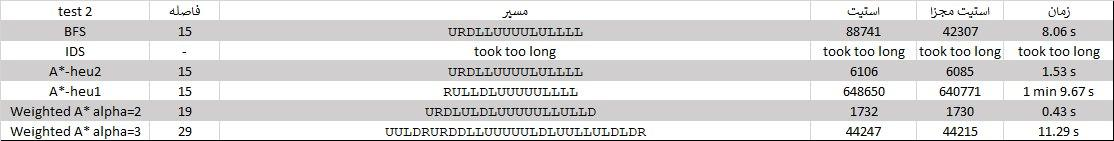

In [ ]:
import copy
from datetime import datetime


In [ ]:
class Node:
    def __init__(self, state, moves):
        self.state = state
        # self.cost = cost
        self.moves=moves
        self.explored = set([])
        self.depth = 0
        self.cost = 0
        self.f = 0
        self.h = 0 
        self.g = 0
        

In [ ]:
class Snake:
    def __init__(self, makans):
        self.makans = makans
        

In [ ]:
class State:
  def __init__(self, makans, doones):
    self.makans = makans 
    self.doones = doones 

  def create_state_for_hash(self):
        khoone = []
        for (y, x) in self.makans:
            khoone.append(y)
            khoone.append(x)
        
        for y, x, adad in self.doones:
            khoone.append(y)
            khoone.append(x)
            khoone.append(adad)
            
        return tuple(khoone)
  
  def __hash__(self):
     return hash(self.create_state_for_hash())

  def __eq__(self, other):
    return  self.create_state_for_hash() == other.create_state_for_hash()



In [ ]:
class Problem:
    def __init__(self, width, height):
        self.width  = width
        self.height = height
    
    def create_state(self, snake, doones):
        doone = []
        makans = snake.makans.copy()
        for d in doones:
            doone.append((d.y, d.x, d.adad))
            
        return State(makans, doone)

    def doit(self, node, action):
      node = copy.deepcopy(node)
      sar = node.state.makans[-1]

      if action == 0:  
        node.state.makans.append(((sar[0] - 1)%self.height, sar[1] ))
        node.moves.append('U')
      
      elif action == 2:
        node.state.makans.append(((sar[0] + 1)%self.height, sar[1] ))
        node.moves.append('D')

      elif action == 1:
         node.state.makans.append((sar[0], (sar[1] - 1)% self.width ))
         node.moves.append('L')
        
      elif action == 3:
         node.state.makans.append((sar[0], (sar[1] + 1)% self.width ))
         node.moves.append('R')

      for cnt, (y, x, adad) in enumerate(node.state.doones):
         if (y, x) == node.state.makans[-1] and adad > 0:
           node.state.doones[cnt] = (y, x, adad-1)
           return node
      
      node.state.makans.pop(0)
      return node 
    
    def possible_actions(self, state):
        height = self.height 
        width = self.width 

        possible_actions = [1, 1, 1, 1]
        sar=state.makans[-1]
        left=(sar[0]%height, (sar[1]-1)%width)
        right=(sar[0]%height, (sar[1]+1)%width)
        up=((sar[0]-1)%height, sar[1]%width)
        down=((sar[0]+1)%height, (sar[1])%width)
        if up in state.makans[0:-1]:
            possible_actions[0] = 0
        
        if left in state.makans[0:-1]:
            possible_actions[1] = 0
        
        if down in state.makans[0:-1]:
            possible_actions[2] = 0
        
        if right in state.makans[0:-1]:
            possible_actions[3] = 0
        
        for y, x, adad in state.doones:
            if (y, x)==up and adad!=0 and up==state.makans[-1]:
                 possible_actions[0] = 0
            
            if (y,x)==left and adad!=0 and left==state.makans[-1]:
                 possible_actions[1] = 0
        
            if (y,x)==down and adad!=0 and down==state.makans[-1]:
                 possible_actions[2] = 0
        
        
            if (y,x)==right and adad!=0 and right==state.makans[-1]:
                 possible_actions[3] = 0
        
        return possible_actions
    

          
    

In [ ]:
class BFS:
    def __init__(self, problem, snake, doones):
        self.problem = problem 
        self.snake = snake
        self.doones = doones
        self.frontier = []
        self.st_cnt = 0
        self.diff_st_cnt = 0 
        

    def goal_test(self, state):
        for y, x, adad in state.doones:
          if adad != 0:
            return False
        
        return True


    def bfs_search(self):
        init_state = self.problem.create_state(self.snake, self.doones)
        node = Node(init_state, [])
        frontier = []
        if self.goal_test(node.state) == True: return node.moves

        frontier_set = set([])
        explored = set([])
        
        frontier.append(node)
        self.st_cnt += 1
        self.diff_st_cnt += 1
        frontier_set.add(hash(node.state))

        while True:
          if len(frontier) == 0: return 'Failure'
          node = frontier.pop(0)
          explored.add(hash(node.state))

          possible_actions = [cnt for cnt, a in enumerate(self.problem.possible_actions(node.state)) if a == 1]

          for action in possible_actions:
            child = self.problem.doit(node, action)
            self.st_cnt += 1
            if (hash(child.state) not in explored) and (hash(child.state) not in frontier_set):
              self.diff_st_cnt += 1
              if self.goal_test(child.state):
                return child.moves
              
              frontier.append(child)
              frontier_set.add(hash(child.state))

          # return 
          
   

In [ ]:
class Doone:
    def __init__(self, y, x, adad):
        self.x = x
        self.y = y
        self.adad = adad
        
    

In [ ]:
class IDS:
    def __init__(self, problem, snake, doones):
        self.problem = problem 
        self.snake = snake
        self.doones = doones
        self.frontier = []
        self.last_nodes = []
        self.st_cnt = 0
        self.diff_st_cnt = 0
        
        # self.initnode = node

    def goal_test(self, state):
        # print(state.doones)
        for y, x, adad in state.doones:
          if adad != 0:
            return False
        
        return True

    def recursive_DLS(self, node, limit, explored):
      if self.goal_test(node.state): return node.moves
      elif limit == 0: return 'cutoff'
      else:
        is_cutoff = False 
        possible_actions = [cnt for cnt, a in enumerate(self.problem.possible_actions(node.state)) if a == 1]
        explored.add(hash(node.state))
        for action in possible_actions:
          child = self.problem.doit(node, action)
          self.st_cnt += 1
          if hash(child.state) in explored: continue 
          # print(child.moves)
          self.diff_st_cnt += 1
          explored.add(hash(child.state))
          result = self.recursive_DLS(child, limit-1, copy.copy(explored))
          if result == 'cutoff': is_cutoff = True
          elif result != 'failure': return result 

        if is_cutoff == True: return 'cutoff'
        else: return 'failure'

    def depth_limited_search(self, limit):
      init_state = self.problem.create_state(self.snake, self.doones)
      # print('dfdfdfdf')
      node = Node(init_state, [])
      explored = set([])
      self.st_cnt += 1
      return self.recursive_DLS(node, limit, explored)

    def IDS(self):
      for limit in range(1, 100, 1):
        result = self.depth_limited_search(limit)
        if result != 'cutoff': return result 

    def IDS2(self, limit):
      init_state = self.problem.create_state(self.snake, self.doones)
      node = Node(init_state, [])
      node.depth = 0
      frontier = []
      if self.goal_test(node.state) == True: return node.moves      
      
      frontier.append(node)
      if limit > 1:
        frontier = copy.copy(self.last_nodes)
        self.last_nodes = []
      
      while True:
        if len(frontier) == 0: return 'failure'
        node = frontier.pop(-1)
        node.explored.add(hash(node.state))

        possible_actions = [cnt for cnt, a in enumerate(self.problem.possible_actions(node.state)) if a == 1]

        for action in possible_actions:
          child = self.problem.doit(node, action)
          child.explored = copy.copy(node.explored)

          child.explored.add(hash(child.state))
          child.depth = node.depth + 1 
          # print(child.moves)
          # print(child.state.makans)
          # print(child.state.doones)
          
          if (hash(child.state) not in node.explored) :
            if self.goal_test(child.state):
              return child.moves
            
            if child.depth < limit:
              frontier.append(child)
            else:
              self.last_nodes.append(child)

    def iterative2(self):
      for l in range(1, 100):
        print(l)
        result = self.IDS2(l)
        # print(result)
        if result != 'failure':
          return result 
      
      return 'failure'

    

In [ ]:
class A_star:
    def __init__(self, problem, snake, doones):
        self.problem = problem 
        self.snake = snake
        self.doones = doones
        self.frontier = []
        self.last_nodes = []
        self.st_cnt = 0
        self.diff_st_cnt = 0
        
        # self.initnode = node

    def goal_test(self, state):
        # print(state.doones)
        for y, x, adad in state.doones:
          if adad != 0:
            return False
        
        return True

    def find_distance(self, p1, p2):
       w = self.problem.width
       h = self.problem.height 

       offsets_y = [h, -h, 0]
       offsets_x = [w, -w, 0]
       d_s = []

       for o_y in offsets_y:
         for o_x in offsets_x:
           d_s.append(abs(p1[0]+o_y - p2[0]) + abs(p1[1]+o_x - p2[1]))

       return min(d_s)
    
    
    def find_min_dis(self, state):
      d_s = []
      for y1, x1, adad1 in state.doones:
        for y2, x2, adad2 in state.doones:
          if (y1, x1) != (y2, x2):
            d_s.append(self.find_distance((y1, x1), (y2, x2)))

      return min(d_s)

    def heuristic2(self, state):
        sar = (state.makans[-1][0], state.makans[-1][1])
        d_s = []
        h = 0
        a = 0
        num = 0
        for y, x, adad in state.doones:
          if adad > 0:
            d_s.append(self.find_distance(sar, (y, x))) 
            a += 1
            if adad == 2: a += len(state.makans) + 1
            num += 1
          
            
        if len(d_s) >  0    :
          m = min(d_s)
          return m + a - 1 + (num-1) * self.find_min_dis(state)
        else:
          return 0 + a

    def heuristic(self, state):
        h = 0
        sar = state.makans[-1]
        for y, x, adad in state.doones:
            h += adad

        return h 

    def a_star(self, node, f_limit, explored, heu, weight=1):
      if self.goal_test(node.state): 
        return node.moves, None

      successors = []
      explored.add(hash(node.state))

      possible_actions = [cnt for cnt, a in enumerate(self.problem.possible_actions(node.state)) if a == 1]

      for action in possible_actions:
        child = self.problem.doit(node, action)
        self.st_cnt += 1
        if hash(child.state) in explored: continue 
        self.diff_st_cnt += 1
        child.g = node.g + 1
        child.h = heu(child.state)
        successors.append(child)

      if len(successors) == 0:
        return 'failure', 10000

      for s in successors:
        s.f = max(s.g + weight*s.h, node.f)
        # print(s.moves)

      while True:
        successors = sorted(successors, key=lambda x: x.f)
        best = successors[0]
        if best.f > f_limit:
          return 'failure', best.f

        if len(successors) > 1:
          alt = successors[1].f
        else:
          alt = f_limit

        result, best.f = self.a_star(copy.deepcopy(best), min(f_limit, alt), copy.copy(explored), heu, weight)
        if result != 'failure':
          return result, None 

    def recursive_best_first_search(self, heu=2, weight=1):
      init_state = self.problem.create_state(self.snake, self.doones)
      node = Node(init_state, [])
      heu = self.heuristic if heu == 1 else self.heuristic2
      node.h = heu(node.state)
      node.f = weight*node.h 
      explored = set([])
      return self.a_star(node, 10000, explored, heu, weight)


In [ ]:
class File_reader:
  def __init__(self, add):
    self.add = add

  def create_problem(self):
    file1 = open(self.add, 'r') 
    Lines = file1.readlines() 
    doones = []
    for cnt, line in enumerate(Lines): 
        # print(line, cnt)
        if cnt == 0:
          h, w = tuple(map(int, line.split(',')))
          pr = Problem(w, h)

        elif cnt == 1:
          sar = tuple(map(int, line.split(',')))
          snake = Snake([sar])

        elif cnt == 2:
          continue

        else:
          h, w, adad = tuple(map(int, line.split(',')))          
          doones.append(Doone(h, w, adad))

    return pr, snake, doones


In [ ]:
def print_sol(sol):
  ss = ''
  for s in sol:
    ss += s
  
  print(ss, len(ss))

In [ ]:

fr = File_reader('test1.txt')
pr, snake, doones = fr.create_problem()
bfs = BFS(pr, snake, doones)
st = datetime.now()
sol = bfs.bfs_search()
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(bfs.st_cnt, bfs.diff_st_cnt)

fr = File_reader('test2.txt')
pr, snake, doones = fr.create_problem()
bfs = BFS(pr, snake, doones)
st = datetime.now()
sol = bfs.bfs_search()
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(bfs.st_cnt, bfs.diff_st_cnt)

fr = File_reader('test3.txt')
pr, snake, doones = fr.create_problem()
bfs = BFS(pr, snake, doones)
st = datetime.now()
sol = bfs.bfs_search()
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(bfs.st_cnt, bfs.diff_st_cnt)

LDLUUULLUULL 12
0:00:00.754134
9541 4694
URDLLUUUULULLLL 15
0:00:08.061609
88741 42307
URDDDRDRRDDRRRUULLLDDRRRURR 27
0:01:02.850090
629676 277358


In [ ]:
fr = File_reader('test1.txt')
pr, snake, doones = fr.create_problem()
ids = IDS(pr, snake, doones)
st = datetime.now()
sol = ids.IDS()
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(bfs.st_cnt, bfs.diff_st_cnt)

# fr = File_reader('test2.txt')
# pr, snake, doones = fr.create_problem()
# ids = IDS(pr, snake, doones)
# st = datetime.now()
# print(ids.IDS())
# print(datetime.now() - st)
# print(bfs.st_cnt, bfs.diff_st_cnt)

# fr = File_reader('test3.txt')
# pr, snake, doones = fr.create_problem()
# ids = IDS(pr, snake, doones)
# st = datetime.now()
# print(ids.IDS())
# print(datetime.now() - st)
# print(bfs.st_cnt, bfs.diff_st_cnt)

LDLUUULLUULL 12
0:00:45.845102
629676 277358


In [ ]:
fr = File_reader('test1.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=1)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test2.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=1)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test3.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=1)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)



LDLUUULLUULL 12
0:00:00.072277
401 371
URDLLUUUULULLLL 15
0:00:01.533210
6106 6085
URDDDRDRRDDRRRUURDRDLLUULLL 27
0:00:01.367918
7250 6839


In [ ]:
fr = File_reader('test1.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=1, weight=1)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test2.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=1, weight=1)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

# fr = File_reader('test3.txt')
# pr, snake, doones = fr.create_problem()
# a_s = A_star(pr, snake, doones)
# st = datetime.now()
# print(a_s.recursive_best_first_search(heu=1, weight=1))
# print(datetime.now() - st)
# print(a_s.st_cnt, a_s.diff_st_cnt)




LDLUUULLUULL 12
0:00:06.190135
65753 64056
RULLDLUUUUULLLL 15
0:01:09.672149
648650 640771


In [ ]:
fr = File_reader('test1.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=2)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test2.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=2)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test3.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=2)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)


LDLUUUULLDRDDLLLD 17
0:00:00.015548
89 86
URDLULDLUUUUULLULLD 19
0:00:00.432431
1732 1730
RURDDLDRDRRURDDDRRUUULLULDDLLLLULDDLUULDDLDR 44
0:00:00.038535
179 177


In [ ]:
fr = File_reader('test1.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=3)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test2.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=3)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)

fr = File_reader('test3.txt')
pr, snake, doones = fr.create_problem()
a_s = A_star(pr, snake, doones)
st = datetime.now()
sol, _ = a_s.recursive_best_first_search(heu=2, weight=3)
dur = datetime.now() - st
print_sol(sol)
print(dur)
print(a_s.st_cnt, a_s.diff_st_cnt)


LLDRUULUUUUUULUURRDLLLUUUU 26
0:00:00.033297
194 189
UULDRURDDLLUUUUULDLUULLULDLDR 29
0:00:11.291474
44247 44215
RURDLDDDRURDDRUUULDLDRRDLLLULLLLDDLUUUURUUUUUUUUUURURDDLDLDRDRU 63
0:00:00.046880
204 201
